In [5]:
import os
import sys
import time
import glob
import json
import numpy as np
import logging
import argparse

import matplotlib.pyplot as plt
import datetime
import pytz

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

from google.colab import files

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# utils

## other

In [7]:
def argspace(**kwds):
  def deco(f):
    def inner(**ikwds):
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [8]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [9]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [10]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(0, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      return [g(*args, **kwds) for _, g in self.func[key].values()]
    return f

  def event(*key):
    def d(f):
      for k in key:
        Experiment()._store(k, f)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [11]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [12]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [13]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

## save

In [14]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [15]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [16]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [17]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  # TODO : init for mount drive
  
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [20]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

# dataset

In [21]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [22]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

In [23]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [24]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if channel_in != channel_out or stride > 1:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [25]:
class Block(nn.Module):
  def __init__(self, index, in_channel, out_channel, stride, shortcuts):
    super(Block, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace=True)
    self.stride = stride
    if stride: self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.shortcuts = self._make_shortcuts(shortcuts)
    self.enable = len(self.shortcuts) > 0
    self.index = index
    self.connection = [i for i, _, _, _ in shortcuts]

  def _make_shortcuts(self, shortcuts):
    layers = nn.ModuleList()
    for (index, i, o, s) in shortcuts:
      layers += [Shortcut(i, o, s)]
    return layers

  def forward(self, x, xs, alpha):
    output = self.bn(self.conv(x))

    if self.enable:
      # shortcut
      cut = sum(alpha[i] * F(xs[i]) for i, F in enumerate(self.shortcuts))
      output = output + cut
    
    output = self.relu(output)

    if self.stride:
      output = self.pool(output)

    return output

In [26]:
class Network(nn.Module):
  def __init__(self, gene):
    super(Network, self).__init__()
    self.gene = gene
    self.blocks = self._make_blocks(gene)
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _decode_gene(self, gene):
    ch, st = [], []
    for g in gene:
      if g == 'M':
        st[-1] *= 2
      else :
        ch += [g]
        st += [1]
    return ch, st

  def _make_blocks(self, gene):
    channel, stride = self._decode_gene(gene)
    s_stride = self.__pi(stride)
    blocks = nn.ModuleList()
    in_channel = 3
    for i, (c, s) in enumerate(zip(channel, stride)):
      setting = []
      for j in range(i-1):
        setting += [(j, channel[j], c, int(s_stride[i-1] / s_stride[j]))]
      blocks += [Block(i, in_channel, c, s>1, setting)]
      in_channel = c
    return blocks

  def _init_alpha(self, blocks, device, delta=1e-3):
    alpha = []

    for block in blocks:
      a = delta * torch.randn(len(block.connection))
      alpha += [torch.tensor(a, requires_grad=True, device=device)]

    return alpha
  
  def init_alpha(self, device):
    self.alphas = self._init_alpha(self.blocks, device)
    return self

  def __pi(self, array):
    r = []
    s = 1
    for q in array:
      s *= q
      r += [s]
    return r

  def forward(self, x):
    state = []

    for idx, block in enumerate(self.blocks):
      xs = [state[i] for i in block.connection]
      x = block(x, xs, F.softmax(self.alphas[idx], dim=0))
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

  @torch.no_grad()
  def alpha_tensor(self, softmax=True):
    alpha = torch.zeros(len(self.alphas), max([len(a) for a in self.alphas]))
    for i, a in enumerate(self.alphas):
      alpha[i, :len(a)] = F.softmax(a, dim=0) if softmax else a
    return alpha

  # def to(self, *args, **kwargs):
  #   with torch.no_grad():
  #     for idx, alpha in enumerate(self.alphas):
  #       self.alphas[idx] = alpha.to(*args, **kwargs)
  #   return super(Network, self).to(*args, **kwargs)

In [27]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device

  def step(self):
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

# learning

In [37]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [29]:
@Experiment.event('checkpoint', 'end')
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [30]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [31]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [38]:
@argspace()
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device

  # model setup
  gene = cfg['VGG11']
  logging.info('gene %s', gene)
  model = Network(gene).to(device).init_alpha(device)

  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  loader = load_dataloader(args)

  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device)


  for epoch in range(args.start_epoch + 1, args.epochs + 1):
    logging.info('epoch %d', epoch)
    # print("grad", model.alphas[0].requires_grad)
    logging.info('alpha %s', model.alpha_tensor())
    logging.info('alpha %s', model.alpha_tensor(softmax=False))

    # training
    train_acc, train_obj = train(dataset=loader.train, model=model, 
                                 criterion=criterion, optimizer=optimizer, 
                                 architect=architect, 
                                 device=device, report_freq=args.report)
    logging.info('train_acc %f', train_acc)
    store.add("train_loss", train_obj)
    store.add("train_acc", train_acc)

    # validation
    valid_acc, valid_obj = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    logging.info('valid_acc %f', valid_acc)
    store.add("test_loss", valid_obj)
    store.add("test_acc", valid_acc)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)
      state = {
        'model': model.state_dict(),
        'alpha': model.alphas,
        'store': store,
        'epoch': epoch,
      }
      torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

  exp('end')(args)
  state = {
    'model': model.state_dict(),
    'alpha': model.alphas,
    'store': store,
    'epoch': epoch,
  }
  torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

# main

learning 1
Experiment dir : variance-2020-09-15_20-03-57
09/15 11:03:57 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_20-03-57', seed=1, test_size=5000, train_size=10000, valid_size=10000)
09/15 11:03:57 AM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 11:03:59 AM epoch 1
09/15 11:03:59 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5004, 0.4996, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3334, 0.3329, 0.3337, 0.0000, 0.0000, 0.0000],
        [0.2499, 0.2498, 0.2499, 0.2503, 0.0000, 0.0000],
        [0.1998, 0.2002, 0.2002, 0.1999, 0.1999, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1665, 0.1667]])
09/15 11:03:59 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.3006e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 4.6236e-05, -1.4311e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

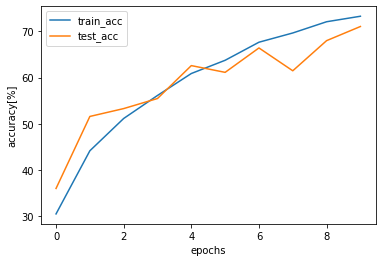

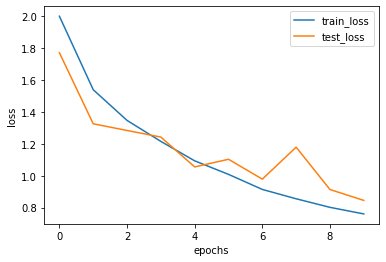

09/15 11:09:32 AM epoch 11
09/15 11:09:32 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2708, 0.7292, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2544, 0.4240, 0.3216, 0.0000, 0.0000, 0.0000],
        [0.1811, 0.2836, 0.1893, 0.3460, 0.0000, 0.0000],
        [0.1607, 0.2314, 0.1625, 0.2617, 0.1838, 0.0000],
        [0.0345, 0.0390, 0.0450, 0.7169, 0.1466, 0.0180]])
09/15 11:09:32 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.3939e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.9543e-01,  4.9512e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.4915e-01,  2.6167e-01, -1.4926e-02,  0.0000e+00,  0.0000e+00

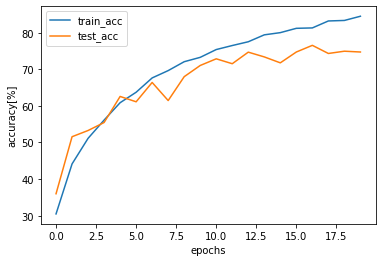

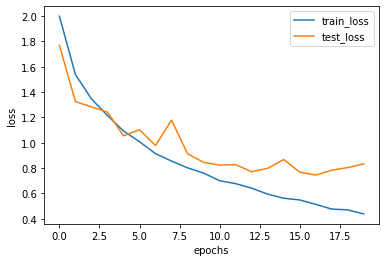

09/15 11:15:05 AM epoch 21
09/15 11:15:05 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9117, 0.0883, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1967, 0.5425, 0.2609, 0.0000, 0.0000, 0.0000],
        [0.1498, 0.3011, 0.1575, 0.3916, 0.0000, 0.0000],
        [0.1204, 0.5033, 0.1134, 0.1520, 0.1108, 0.0000],
        [0.0098, 0.0102, 0.0094, 0.9506, 0.0156, 0.0044]])
09/15 11:15:05 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.7516e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1672e+00, -1.1674e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.4469e-01,  5.6990e-01, -1.6226e-01,  0.0000e+00,  0.0000e+00

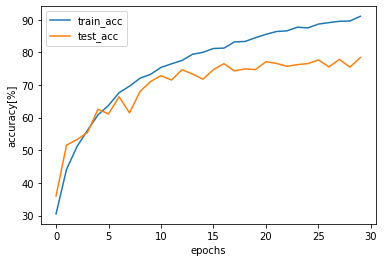

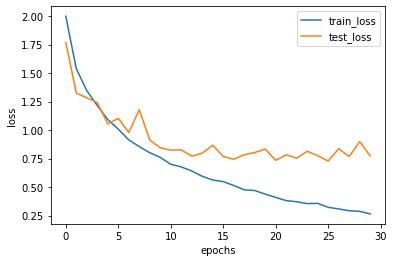

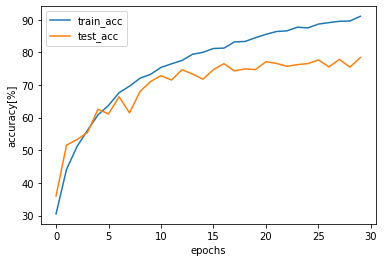

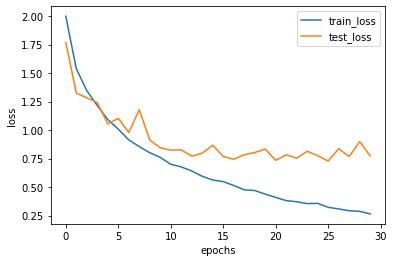

learning 2
Experiment dir : variance-2020-09-15_20-20-42
09/15 11:20:42 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_20-20-42', seed=2, test_size=5000, train_size=10000, valid_size=10000)
09/15 11:20:42 AM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 11:20:44 AM epoch 1
09/15 11:20:44 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5005, 0.4995, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3332, 0.3333, 0.3335, 0.0000, 0.0000, 0.0000],
        [0.2498, 0.2501, 0.2499, 0.2502, 0.0000, 0.0000],
        [0.2001, 0.1995, 0.2002, 0.2001, 0.2002, 0.0000],
        [0.1666, 0.1668, 0.1667, 0.1667, 0.1667, 0.1665]])
09/15 11:20:44 AM alpha tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0016, -0.0006,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0009, -0.0004,  0.0002,  0.0000,  0.0000,  0.0000],
        [-0.0011,  0.0004, -0.0005,  0.0007,  0.0000,  0.0000],
 

Traceback (most recent call last):


09/15 11:25:42 AM train_acc 71.440000
09/15 11:25:42 AM valid 000 1.062593e+00 64.062500 96.875000
09/15 11:25:44 AM valid_acc 62.940000
09/15 11:25:44 AM epoch 10
09/15 11:25:44 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2800, 0.7200, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2518, 0.3470, 0.4012, 0.0000, 0.0000, 0.0000],
        [0.2008, 0.2505, 0.2054, 0.3433, 0.0000, 0.0000],
        [0.1570, 0.1600, 0.2572, 0.2044, 0.2214, 0.0000],
        [0.0463, 0.0736, 0.0657, 0.4883, 0.2946, 0.0315]])
09/15 11:25:44 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.7951e-22,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.7217e-01,  4.7241e-0

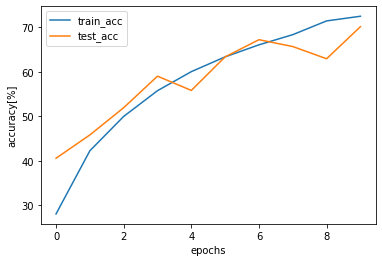

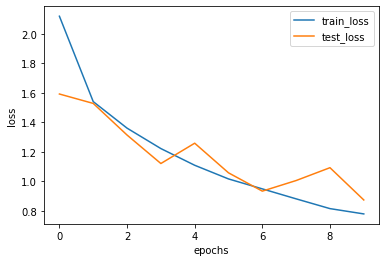

09/15 11:26:18 AM epoch 11
09/15 11:26:18 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3059, 0.6941, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2670, 0.3658, 0.3673, 0.0000, 0.0000, 0.0000],
        [0.2053, 0.2516, 0.1984, 0.3447, 0.0000, 0.0000],
        [0.1519, 0.1609, 0.2308, 0.2279, 0.2285, 0.0000],
        [0.0405, 0.0652, 0.0588, 0.5279, 0.2817, 0.0259]])
09/15 11:26:18 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 9.3796e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.0949e-01,  4.0970e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.1096e-01,  1.0377e-01,  1.0787e-01,  0.0000e+00,  0.0000e+00

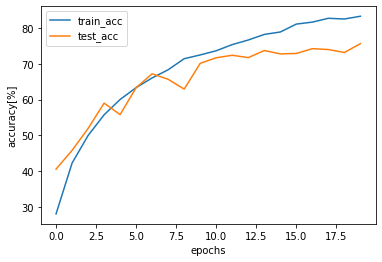

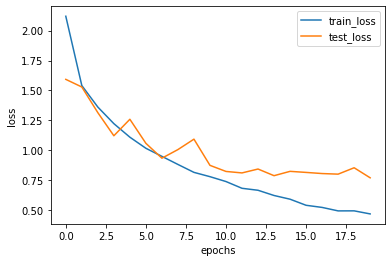

09/15 11:31:47 AM epoch 21
09/15 11:31:47 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7209, 0.2791, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2015, 0.4593, 0.3392, 0.0000, 0.0000, 0.0000],
        [0.1573, 0.4346, 0.1643, 0.2438, 0.0000, 0.0000],
        [0.1432, 0.1121, 0.2486, 0.3028, 0.1933, 0.0000],
        [0.0134, 0.0168, 0.0145, 0.9033, 0.0465, 0.0055]])
09/15 11:31:47 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.1140e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 4.7445e-01, -4.7436e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.5674e-01,  3.6727e-01,  6.4002e-02,  0.0000e+00,  0.0000e+00

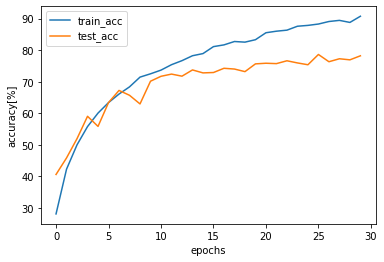

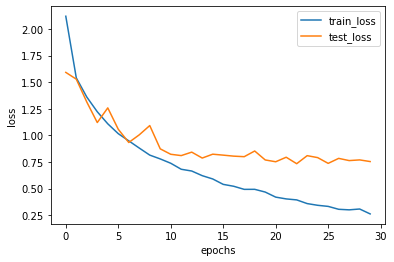

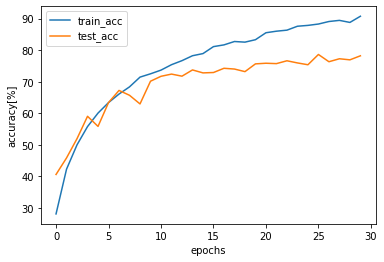

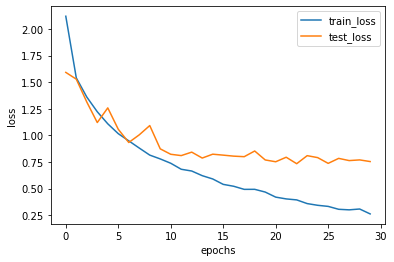

learning 3
Experiment dir : variance-2020-09-15_20-37-23
09/15 11:37:23 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_20-37-23', seed=3, test_size=5000, train_size=10000, valid_size=10000)
09/15 11:37:23 AM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 11:37:25 AM epoch 1
09/15 11:37:25 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5003, 0.4997, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3332, 0.3336, 0.3332, 0.0000, 0.0000, 0.0000],
        [0.2503, 0.2503, 0.2497, 0.2497, 0.0000, 0.0000],
        [0.1999, 0.2002, 0.1998, 0.2000, 0.2001, 0.0000],
        [0.1665, 0.1667, 0.1668, 0.1664, 0.1670, 0.1666]])
09/15 11:37:25 AM alpha tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0005,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0002, -0.0010,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0001,  0.0011,  0.0002,  0.0000,  0.0000,  0.0000],
        [ 0.0011,  0.0014, -0.0011, -0.0011,  0.0000,  0.0000],
 

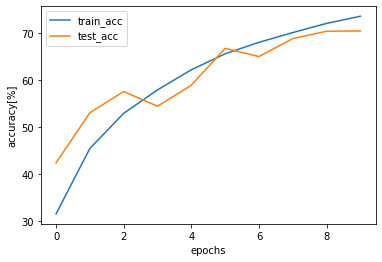

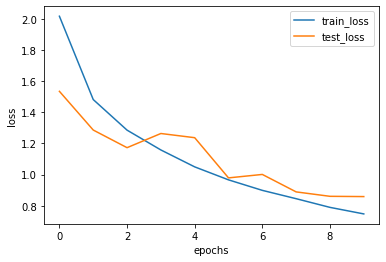

09/15 11:42:58 AM epoch 11
09/15 11:42:58 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3639, 0.6361, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2809, 0.3746, 0.3446, 0.0000, 0.0000, 0.0000],
        [0.1941, 0.2244, 0.2062, 0.3753, 0.0000, 0.0000],
        [0.1854, 0.1870, 0.2259, 0.2313, 0.1704, 0.0000],
        [0.0371, 0.0435, 0.0471, 0.6861, 0.1625, 0.0237]])
09/15 11:42:58 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-6.9905e-30,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.7935e-01,  2.7918e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.6132e-01,  1.2668e-01,  4.3123e-02,  0.0000e+00,  0.0000e+00

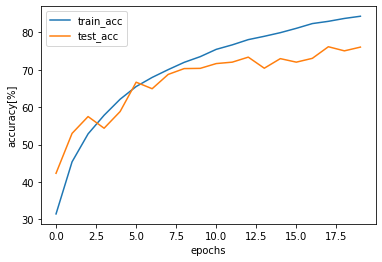

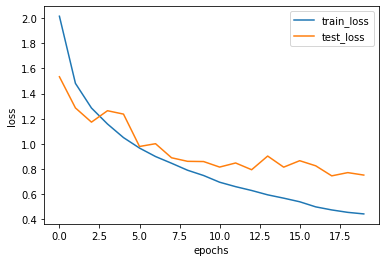

09/15 11:48:30 AM epoch 21
09/15 11:48:30 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8652, 0.1348, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1784, 0.6073, 0.2143, 0.0000, 0.0000, 0.0000],
        [0.1199, 0.2771, 0.1467, 0.4563, 0.0000, 0.0000],
        [0.2008, 0.1945, 0.2780, 0.1654, 0.1614, 0.0000],
        [0.0092, 0.0109, 0.0098, 0.9490, 0.0166, 0.0046]])
09/15 11:48:30 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.8627e-14,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 9.2952e-01, -9.2960e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.9242e-01,  7.3262e-01, -3.0883e-01,  0.0000e+00,  0.0000e+00

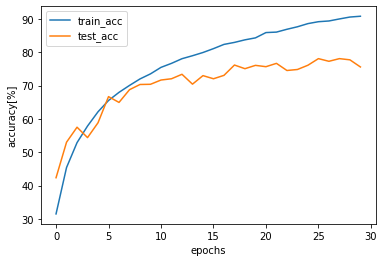

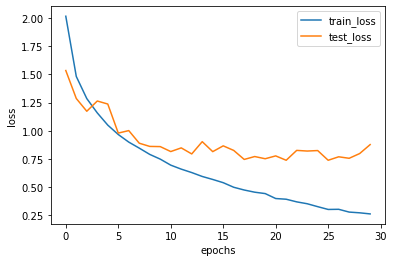

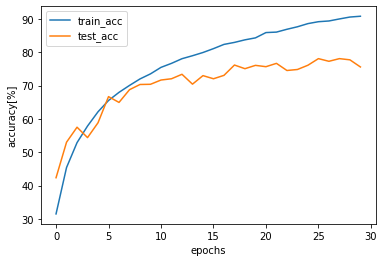

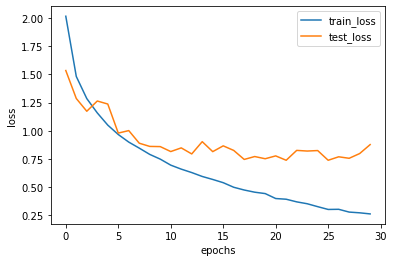

learning 4
Experiment dir : variance-2020-09-15_20-54-06
09/15 11:54:06 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_20-54-06', seed=4, test_size=5000, train_size=10000, valid_size=10000)
09/15 11:54:06 AM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 11:54:08 AM epoch 1
09/15 11:54:08 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4991, 0.5009, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3331, 0.3337, 0.3332, 0.0000, 0.0000, 0.0000],
        [0.2499, 0.2500, 0.2502, 0.2498, 0.0000, 0.0000],
        [0.1999, 0.2000, 0.2001, 0.1997, 0.2003, 0.0000],
        [0.1666, 0.1668, 0.1667, 0.1666, 0.1665, 0.1667]])
09/15 11:54:08 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.9938e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.3888e-03,  2.1688e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

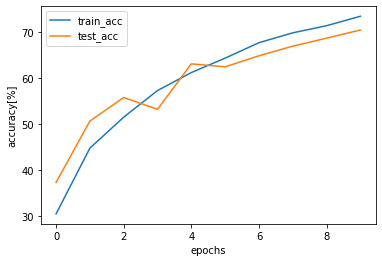

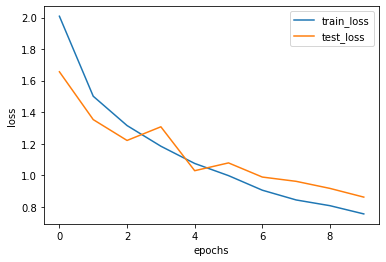

09/15 11:59:42 AM epoch 11
09/15 11:59:42 AM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3366, 0.6634, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3383, 0.2904, 0.3713, 0.0000, 0.0000, 0.0000],
        [0.2170, 0.2967, 0.1868, 0.2996, 0.0000, 0.0000],
        [0.1548, 0.2084, 0.2064, 0.2504, 0.1800, 0.0000],
        [0.0319, 0.0438, 0.0491, 0.6707, 0.1831, 0.0214]])
09/15 11:59:42 AM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.4535e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-3.3910e-01,  3.3925e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.2703e-02, -1.2979e-01,  1.1568e-01,  0.0000e+00,  0.0000e+00

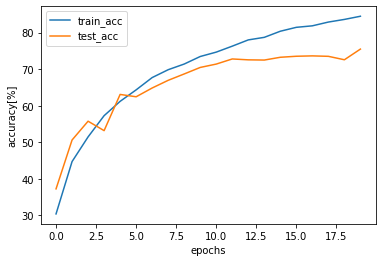

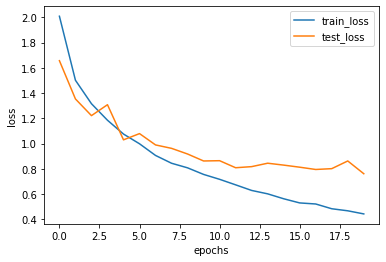

09/15 12:05:15 PM epoch 21
09/15 12:05:15 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9030, 0.0970, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3112, 0.3118, 0.3770, 0.0000, 0.0000, 0.0000],
        [0.1777, 0.3870, 0.1734, 0.2618, 0.0000, 0.0000],
        [0.1196, 0.3657, 0.1998, 0.1788, 0.1362, 0.0000],
        [0.0094, 0.0112, 0.0102, 0.9425, 0.0223, 0.0045]])
09/15 12:05:15 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.3046e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1155e+00, -1.1154e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-6.0559e-02, -5.8837e-02,  1.3127e-01,  0.0000e+00,  0.0000e+00

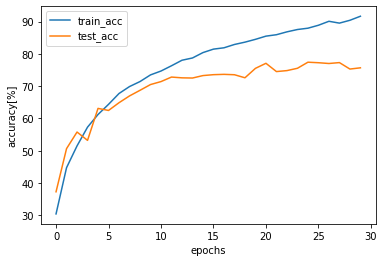

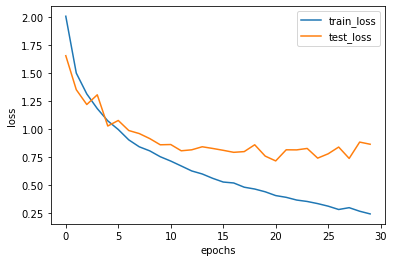

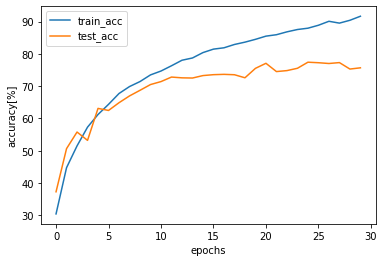

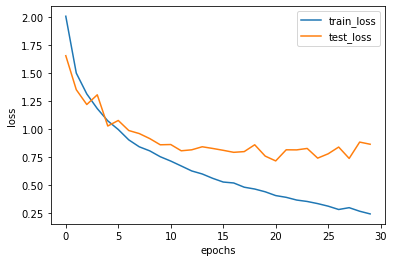

learning 5
Experiment dir : variance-2020-09-15_21-10-52
09/15 12:10:52 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_21-10-52', seed=5, test_size=5000, train_size=10000, valid_size=10000)
09/15 12:10:52 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 12:10:54 PM epoch 1
09/15 12:10:54 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4997, 0.5003, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3334, 0.3336, 0.3330, 0.0000, 0.0000, 0.0000],
        [0.2502, 0.2500, 0.2500, 0.2498, 0.0000, 0.0000],
        [0.2001, 0.2001, 0.1998, 0.2001, 0.1999, 0.0000],
        [0.1669, 0.1667, 0.1666, 0.1665, 0.1669, 0.1664]])
09/15 12:10:54 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.7114e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.8288e-04,  7.6490e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

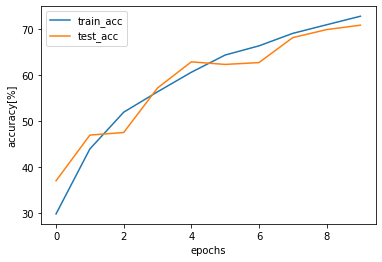

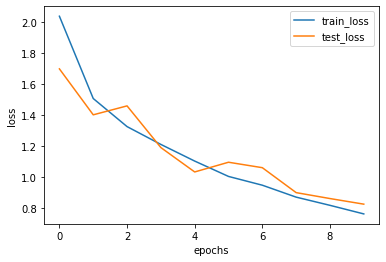

09/15 12:16:27 PM epoch 11
09/15 12:16:27 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4082, 0.5918, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3018, 0.3102, 0.3880, 0.0000, 0.0000, 0.0000],
        [0.1987, 0.2234, 0.2445, 0.3334, 0.0000, 0.0000],
        [0.1654, 0.1657, 0.2028, 0.2784, 0.1878, 0.0000],
        [0.0399, 0.0509, 0.0467, 0.6305, 0.2070, 0.0250]])
09/15 12:16:27 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.0075e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.8558e-01,  1.8564e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-8.8861e-02, -6.1636e-02,  1.6221e-01,  0.0000e+00,  0.0000e+00

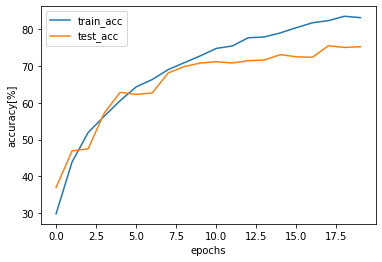

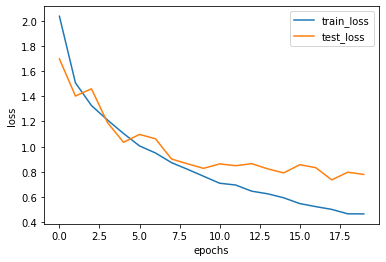

09/15 12:21:59 PM epoch 21
09/15 12:21:59 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8668, 0.1332, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2534, 0.3699, 0.3767, 0.0000, 0.0000, 0.0000],
        [0.1885, 0.2574, 0.2084, 0.3457, 0.0000, 0.0000],
        [0.1259, 0.2830, 0.2080, 0.1957, 0.1874, 0.0000],
        [0.0109, 0.0129, 0.0110, 0.9349, 0.0254, 0.0048]])
09/15 12:21:59 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.6549e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 9.3648e-01, -9.3645e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.6085e-01,  1.1749e-01,  1.3574e-01,  0.0000e+00,  0.0000e+00

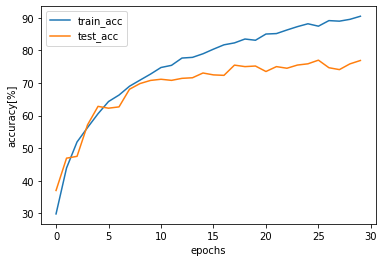

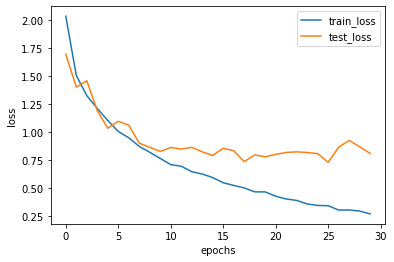

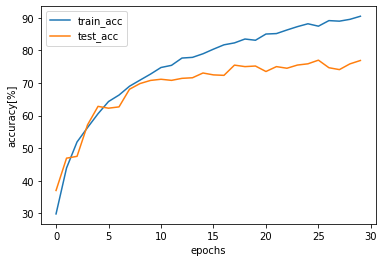

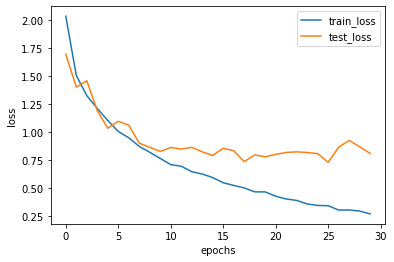

learning 6
Experiment dir : variance-2020-09-15_21-27-34
09/15 12:27:34 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_21-27-34', seed=6, test_size=5000, train_size=10000, valid_size=10000)
09/15 12:27:34 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 12:27:36 PM epoch 1
09/15 12:27:36 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4996, 0.5004, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3331, 0.3334, 0.3335, 0.0000, 0.0000, 0.0000],
        [0.2497, 0.2500, 0.2498, 0.2505, 0.0000, 0.0000],
        [0.2001, 0.2000, 0.2001, 0.1998, 0.2001, 0.0000],
        [0.1666, 0.1670, 0.1665, 0.1668, 0.1666, 0.1665]])
09/15 12:27:36 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.0795e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-9.3690e-04,  6.2780e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

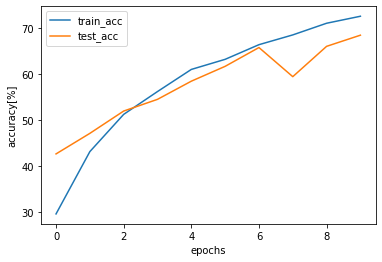

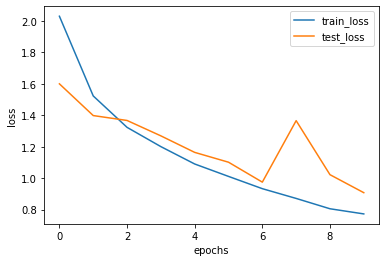

09/15 12:33:08 PM epoch 11
09/15 12:33:08 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3674, 0.6326, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2832, 0.3419, 0.3748, 0.0000, 0.0000, 0.0000],
        [0.2342, 0.2347, 0.2383, 0.2928, 0.0000, 0.0000],
        [0.1930, 0.1798, 0.2253, 0.1783, 0.2236, 0.0000],
        [0.0278, 0.0362, 0.0391, 0.6734, 0.2053, 0.0182]])
09/15 12:33:08 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.8962e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.7179e-01,  2.7173e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.5228e-01,  3.6124e-02,  1.2795e-01,  0.0000e+00,  0.0000e+00

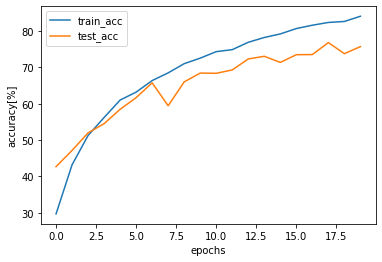

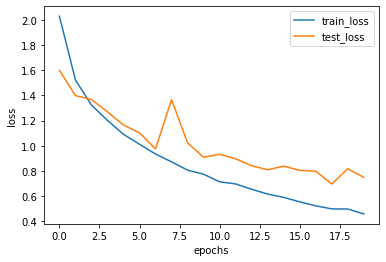

09/15 12:38:41 PM epoch 21
09/15 12:38:41 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8889, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2739, 0.3933, 0.3328, 0.0000, 0.0000, 0.0000],
        [0.2112, 0.2240, 0.1925, 0.3723, 0.0000, 0.0000],
        [0.1882, 0.1540, 0.2762, 0.1860, 0.1956, 0.0000],
        [0.0092, 0.0107, 0.0098, 0.9439, 0.0219, 0.0046]])
09/15 12:38:41 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1512e-31,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.0396e+00, -1.0396e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.8837e-01,  1.7360e-01,  6.3570e-03,  0.0000e+00,  0.0000e+00

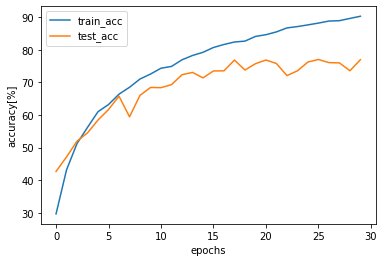

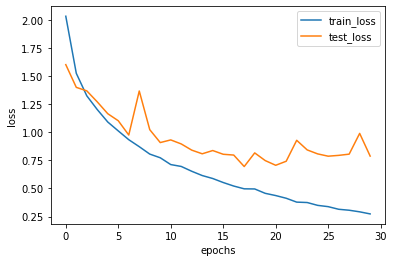

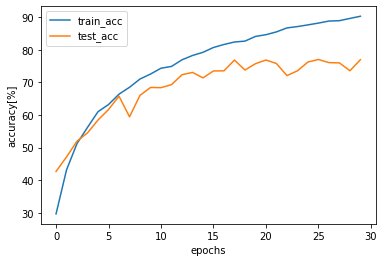

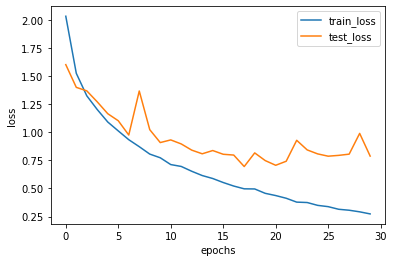

learning 7
Experiment dir : variance-2020-09-15_21-44-18
09/15 12:44:18 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_21-44-18', seed=7, test_size=5000, train_size=10000, valid_size=10000)
09/15 12:44:18 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 12:44:20 PM epoch 1
09/15 12:44:20 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5002, 0.4998, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3331, 0.3334, 0.3335, 0.0000, 0.0000, 0.0000],
        [0.2502, 0.2500, 0.2501, 0.2497, 0.0000, 0.0000],
        [0.2001, 0.2002, 0.2000, 0.1998, 0.1999, 0.0000],
        [0.1668, 0.1666, 0.1666, 0.1670, 0.1665, 0.1665]])
09/15 12:44:20 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.3037e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 5.3659e-04, -9.9450e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

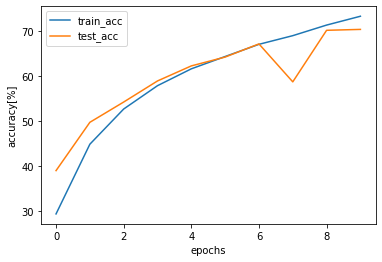

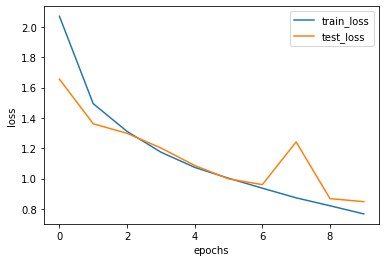

09/15 12:49:53 PM epoch 11
09/15 12:49:53 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5630, 0.4370, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3026, 0.4335, 0.2640, 0.0000, 0.0000, 0.0000],
        [0.1899, 0.2574, 0.1990, 0.3537, 0.0000, 0.0000],
        [0.1767, 0.1879, 0.2599, 0.1994, 0.1762, 0.0000],
        [0.0431, 0.0489, 0.0450, 0.6453, 0.1955, 0.0222]])
09/15 12:49:53 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.3182e-20,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.2670e-01, -1.2659e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-8.3921e-02,  2.7560e-01, -2.2045e-01,  0.0000e+00,  0.0000e+00

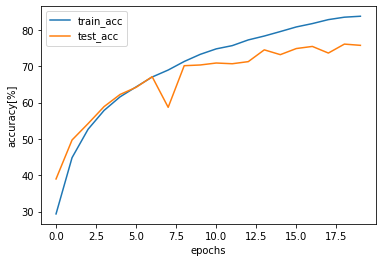

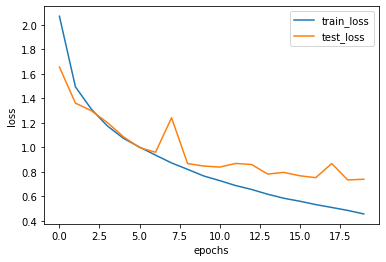

09/15 12:55:27 PM epoch 21
09/15 12:55:27 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8673, 0.1327, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2841, 0.4618, 0.2541, 0.0000, 0.0000, 0.0000],
        [0.1806, 0.4020, 0.1660, 0.2514, 0.0000, 0.0000],
        [0.1438, 0.2452, 0.2183, 0.2516, 0.1411, 0.0000],
        [0.0119, 0.0121, 0.0107, 0.9364, 0.0241, 0.0048]])
09/15 12:55:27 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.0510e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 9.3863e-01, -9.3859e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.2772e-01,  3.5793e-01, -2.3947e-01,  0.0000e+00,  0.0000e+00

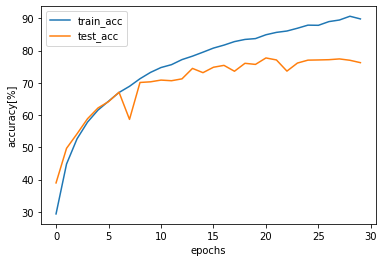

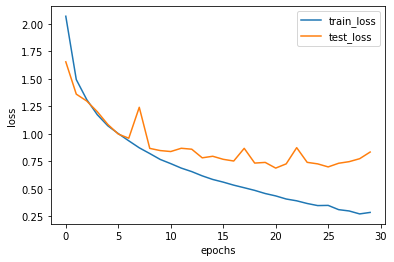

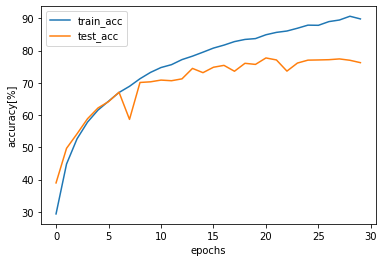

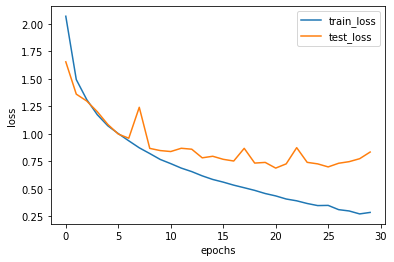

learning 8
Experiment dir : variance-2020-09-15_22-01-05
09/15 01:01:05 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_22-01-05', seed=8, test_size=5000, train_size=10000, valid_size=10000)
09/15 01:01:05 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 01:01:07 PM epoch 1
09/15 01:01:07 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4996, 0.5004, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3334, 0.3329, 0.3336, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2498, 0.2509, 0.2494, 0.0000, 0.0000],
        [0.2002, 0.2003, 0.1997, 0.2000, 0.1998, 0.0000],
        [0.1666, 0.1668, 0.1664, 0.1668, 0.1669, 0.1665]])
09/15 01:01:07 PM alpha tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0015,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0002,  0.0017,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0011, -0.0003,  0.0018,  0.0000,  0.0000,  0.0000],
        [ 0.0005, -0.0002,  0.0040, -0.0020,  0.0000,  0.0000],
 

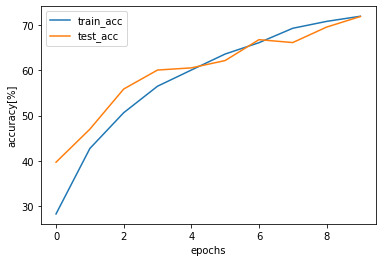

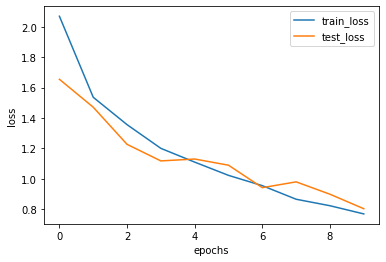

09/15 01:06:42 PM epoch 11
09/15 01:06:42 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2804, 0.7196, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3321, 0.3453, 0.3225, 0.0000, 0.0000, 0.0000],
        [0.1590, 0.2291, 0.2214, 0.3905, 0.0000, 0.0000],
        [0.1749, 0.1925, 0.2033, 0.2368, 0.1924, 0.0000],
        [0.0421, 0.0690, 0.0633, 0.4142, 0.3732, 0.0383]])
09/15 01:06:42 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.9954e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.7108e-01,  4.7149e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.4411e-03,  3.7603e-02, -3.0725e-02,  0.0000e+00,  0.0000e+00

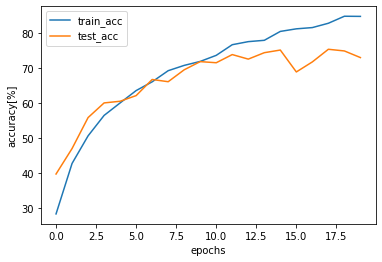

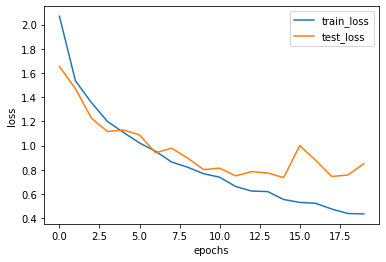

09/15 01:12:16 PM epoch 21
09/15 01:12:16 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5400, 0.4600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2715, 0.3632, 0.3652, 0.0000, 0.0000, 0.0000],
        [0.1490, 0.2273, 0.2282, 0.3955, 0.0000, 0.0000],
        [0.1609, 0.2078, 0.2207, 0.2525, 0.1582, 0.0000],
        [0.0175, 0.0262, 0.0196, 0.7566, 0.1729, 0.0072]])
09/15 01:12:16 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.9954e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 8.0185e-02, -8.0035e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.8853e-01,  1.0241e-01,  1.0792e-01,  0.0000e+00,  0.0000e+00

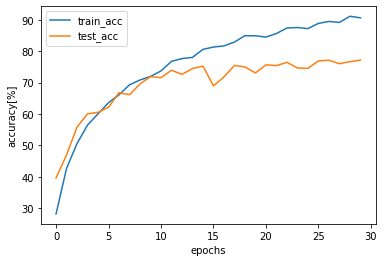

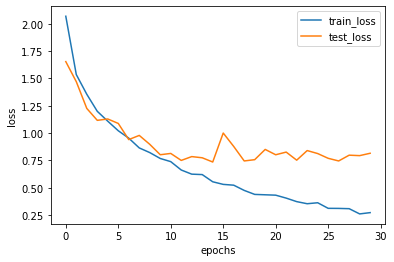

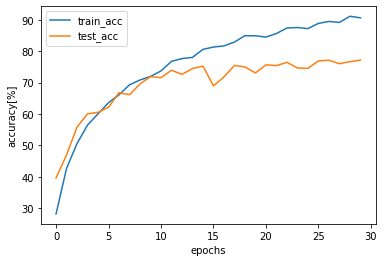

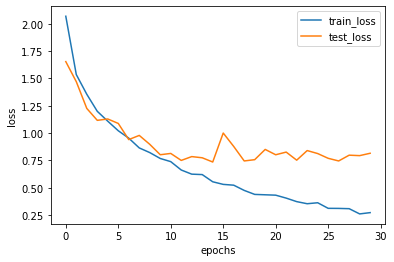

learning 9
Experiment dir : variance-2020-09-15_22-17-53
09/15 01:17:53 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='variance-2020-09-15_22-17-53', seed=9, test_size=5000, train_size=10000, valid_size=10000)
09/15 01:17:53 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/15 01:17:55 PM epoch 1
09/15 01:17:55 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5003, 0.4997, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3331, 0.3336, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2502, 0.2502, 0.2498, 0.2497, 0.0000, 0.0000],
        [0.1999, 0.2000, 0.2002, 0.2000, 0.1999, 0.0000],
        [0.1664, 0.1666, 0.1669, 0.1667, 0.1670, 0.1665]])
09/15 01:17:55 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-8.8880e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.5067e-04, -3.1865e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

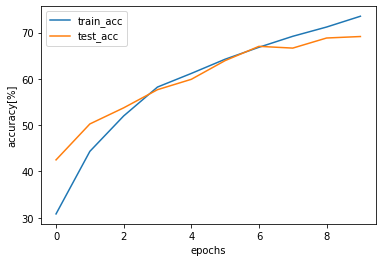

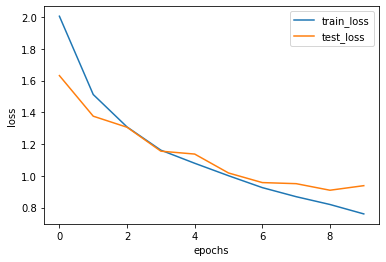

09/15 01:23:29 PM epoch 11
09/15 01:23:29 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5330, 0.4670, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2645, 0.4059, 0.3296, 0.0000, 0.0000, 0.0000],
        [0.1786, 0.2479, 0.2167, 0.3568, 0.0000, 0.0000],
        [0.2283, 0.2822, 0.1828, 0.1614, 0.1453, 0.0000],
        [0.0311, 0.0383, 0.0396, 0.6788, 0.1883, 0.0238]])
09/15 01:23:29 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.3803e-29,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 6.6203e-02, -6.6101e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.1957e-01,  2.0887e-01,  7.3712e-04,  0.0000e+00,  0.0000e+00

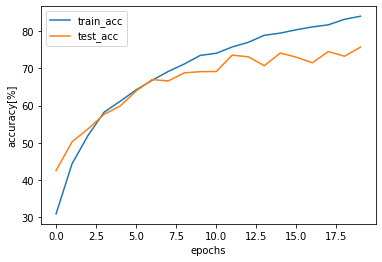

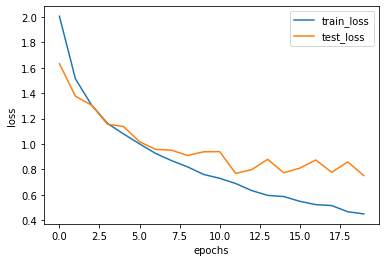

09/15 01:29:05 PM epoch 21
09/15 01:29:05 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8832, 0.1168, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1824, 0.5958, 0.2218, 0.0000, 0.0000, 0.0000],
        [0.2073, 0.3303, 0.1547, 0.3077, 0.0000, 0.0000],
        [0.6171, 0.1502, 0.0834, 0.0718, 0.0775, 0.0000],
        [0.0079, 0.0091, 0.0084, 0.9537, 0.0164, 0.0044]])
09/15 01:29:05 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.0234e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.0115e+00, -1.0115e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.9042e-01,  6.9305e-01, -2.9512e-01,  0.0000e+00,  0.0000e+00

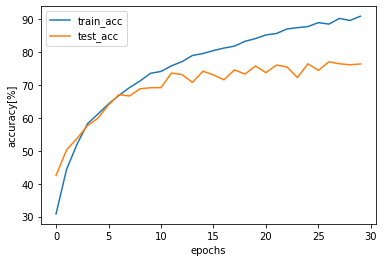

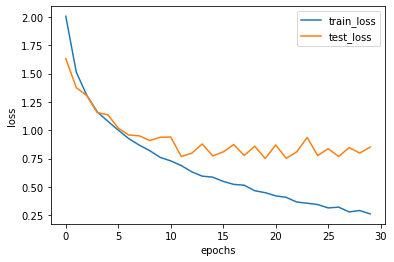

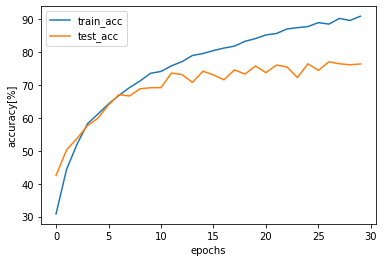

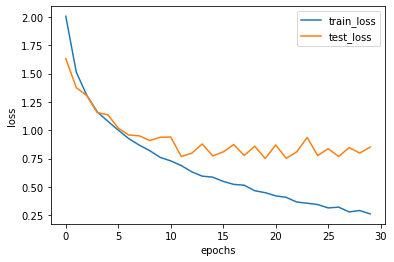

In [42]:
if __name__ == '__main__':
  for i in range(1, 10):
    print("=" * 40)
    print("learning %d" % i)
    main(save="variance", lr=0.01, momentum=0.9, lr_alpha=0.005, epochs=30, 
        train_size=10000, valid_size=10000, test_size=5000, batch_size=64, 
        seed=i, report=100, checkpoint=10, dir="")

# exp

TODO
- watch model size, memory
- early stopping